In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-signs-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F545505%2F1000084%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T175729Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dc8c07e841ebb30c4ee54db8109b68078d5d1a49bfc21a460057c440fad646fb4c485e1077484b0eedac184e1865e543cbb3d67eaacd861b106994fd98360e80715a209629722400e4f33f84f1e30c493af484fd8f7f5d9361be8a485a1d1ba49f72c7253f53bcce1ebbdf5f3ec7092913536c92487fe439dedccd14966b2167c60d6a3589a0542ed9b3fc643909b062ac86f1f6cec61f2807c76231cfb330d92225722b9702e8468539cf645fcd35bbf0d6fe2f06f39fff4a347846cfb6ba6fc108e123136b45a56cbb9863a70dbb692c3aab79982cd429b8a275c05f8c539281dc83c433c74fb61711efa8fb6293938fdccc981ffcd0d4403d22c8a3bfc7b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 68679820 bytes downloaded
Downloaded and uncompressed: traffic-signs-classification
Data source import complete.


# Taffic Sign Classification

Traffic Sign Classification Using **Convolutional Neural Networks(CNNs)**, Which is widely used in various applications in the field of Artificial Intelligence. This notebook focuses on developing a deep learning model in order to classify the traffic signs.🛑❌🚫🚷🚳

![taffic_signs](https://www.nevron.com/NIMG.axd?i=Diagram/Shapes/TrafficSignsShapes/Traffic_signs_shapes.png)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
!ls -l /kaggle/input/traffic-signs-classification

total 4460
-rw-r--r--  1 root root     863 Jun  1 17:58 extract.py
-rw-r--r--  1 root root    1037 Jun  1 17:58 labels.csv
-rw-r--r--  1 root root 4552523 Jun  1 17:58 model_trained.p
drwxr-xr-x 45 root root    4096 Jun  1 17:58 myData


## Importing Libraries

In [3]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.15.0


## Reading Data of Class Labels

In [4]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')


## Visualizing countplot of the classes

<ipython-input-5-fccbbe83799a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')


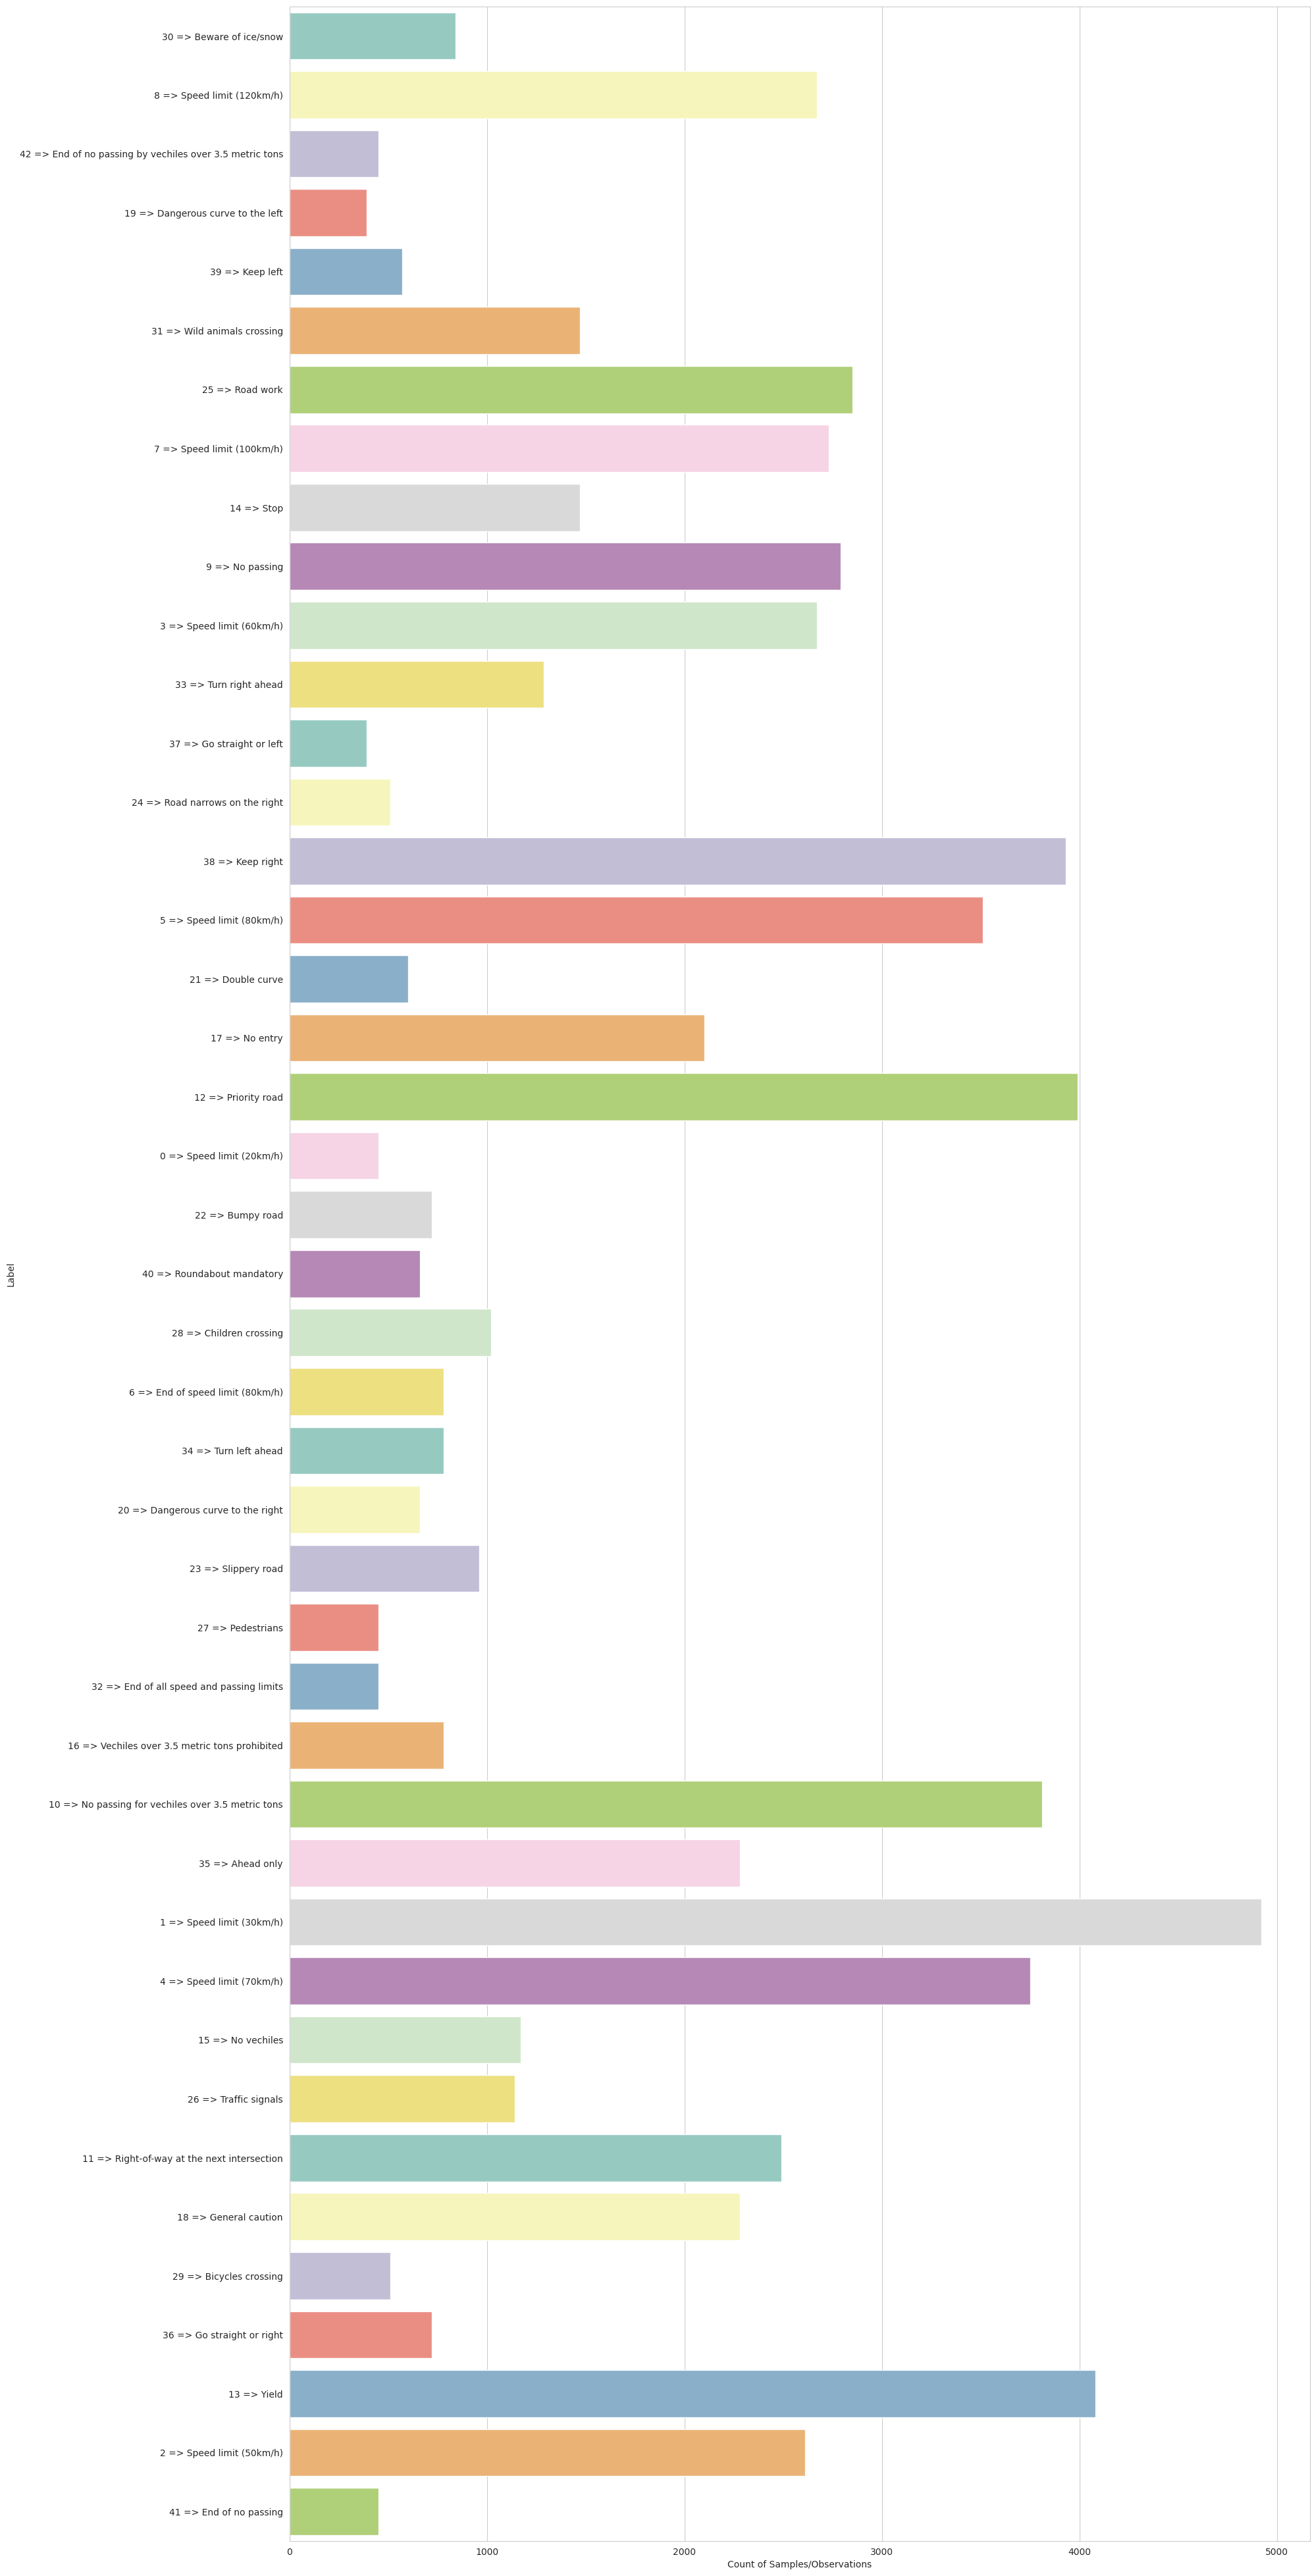

In [5]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

## Reading Image Data

In [6]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [7]:
X , y = data.next()

In [8]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


## Sample Images of Dataset

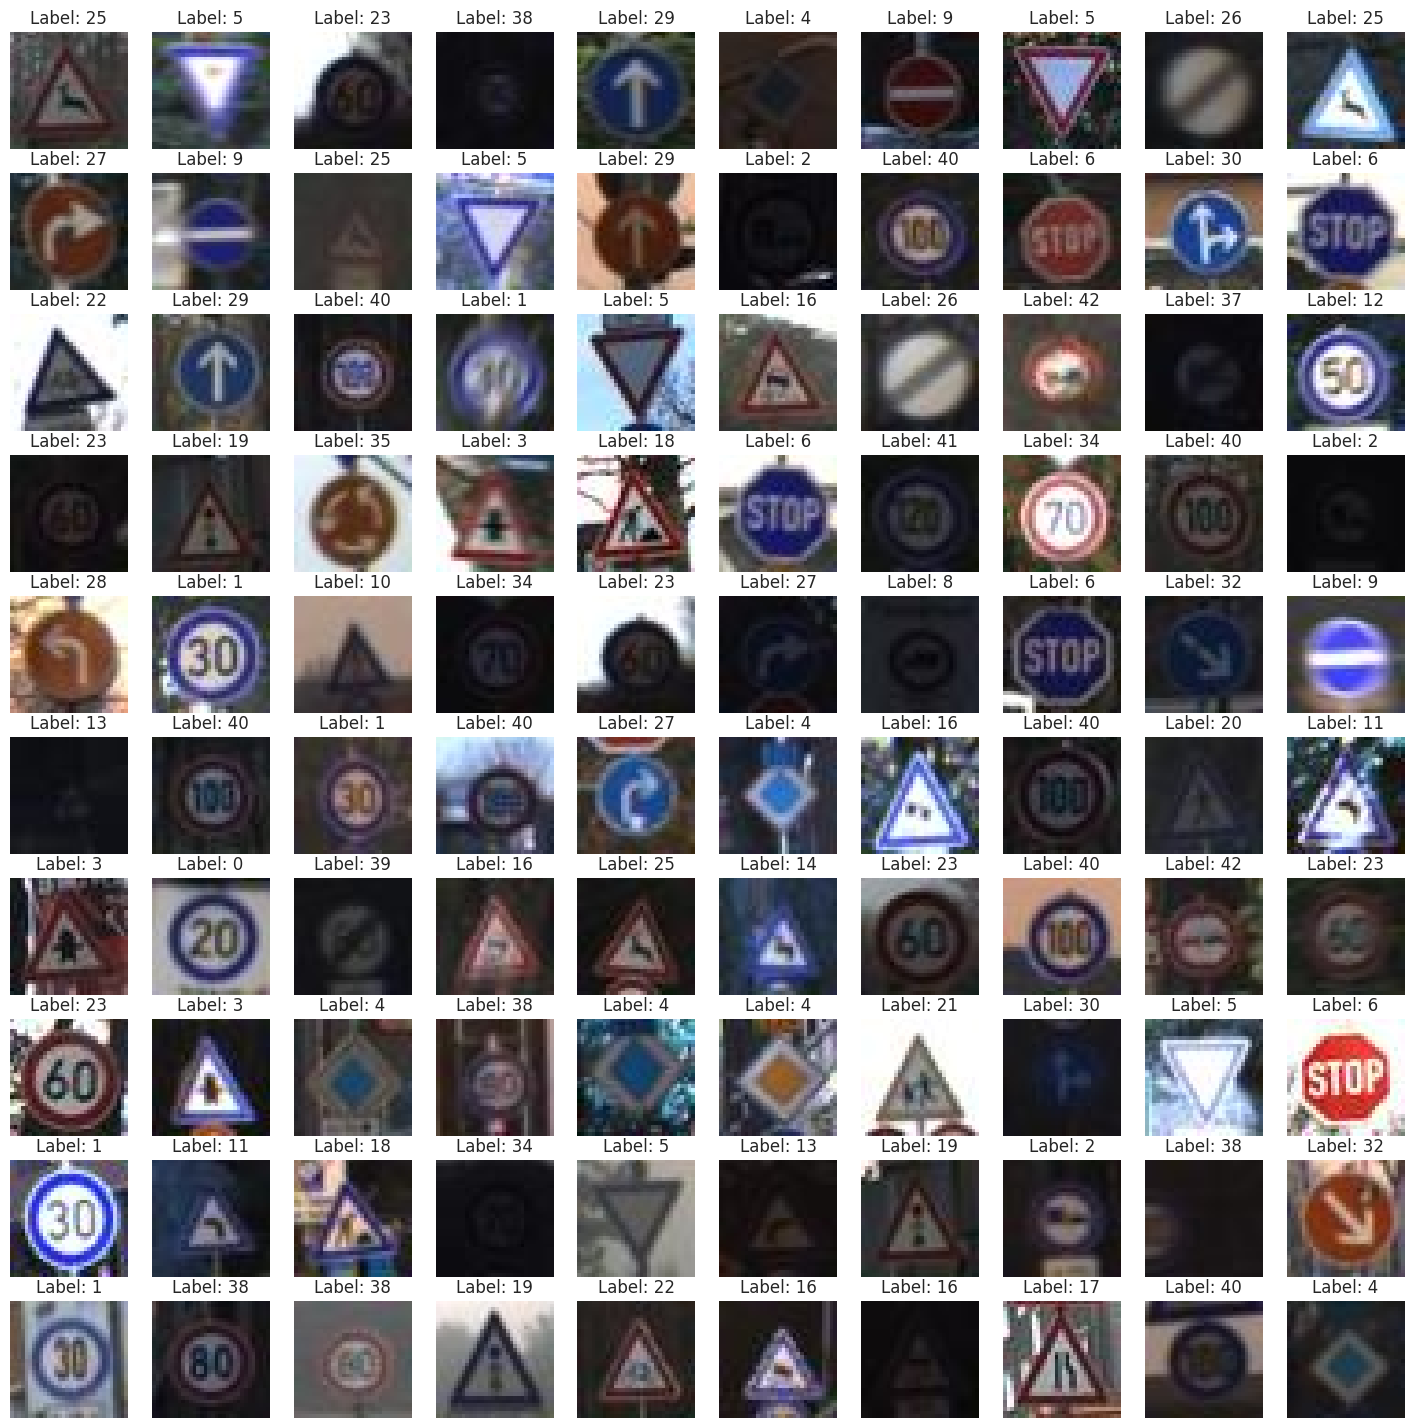

In [9]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))



## Dividing data into **train** and **test** in the split percentage of 80:20

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [11]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


## Customising ResNet50 model  

In [12]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [13]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Visualising Model Architecture

In [15]:
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.478672 to fit



## Compiling the Model

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [17]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')


## Fitting Model with Data

In [18]:
n_epochs = 50
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1,
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
1829/1829 [==============================] - ETA: 0s - loss: 4.1383 - accuracy: 0.1638

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1829/1829 [==============================] - 126s 49ms/step - loss: 4.1383 - accuracy: 0.1638 - val_loss: 264.2067 - val_accuracy: 0.0916 - lr: 0.0010
Epoch 2/50
1829/1829 [==============================] - 82s 45ms/step - loss: 2.2492 - accuracy: 0.5429 - val_loss: 8.0408 - val_accuracy: 0.6661 - lr: 0.0010
Epoch 3/50
1829/1829 [==============================] - 83s 45ms/step - loss: 1.8131 - accuracy: 0.6309 - val_loss: 1.6071 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 4/50
1829/1829 [==============================] - 86s 47ms/step - loss: 1.0874 - accuracy: 0.7688 - val_loss: 0.4891 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 5/50
1829/1829 [==============================] - 85s 46ms/step - loss: 0.4520 - accuracy: 0.8667 - val_loss: 0.2116 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 6/50
1829/1829 [==============================] - 88s 48ms/step - loss: 0.2749 - accuracy: 0.9219 - val_loss: 0.1680 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 7/50
1829/1829 [==============================] 

In [19]:
# Saving the model
model.save('TSC_model.h5')

In [20]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

458/458 [==============================] - 5s 10ms/step - loss: 0.0350 - accuracy: 0.9914
Accuracy:  0.991386353969574 
Loss    :  0.03499523550271988


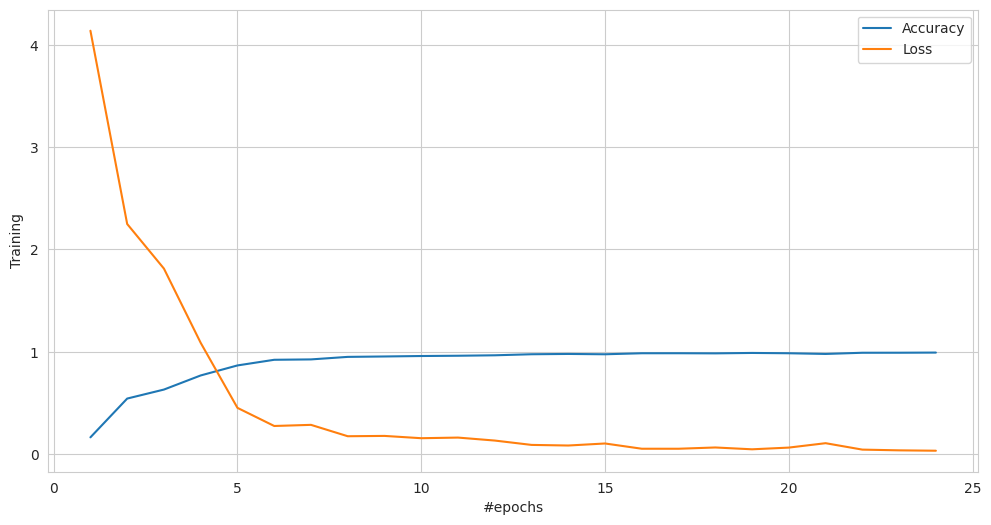

In [21]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

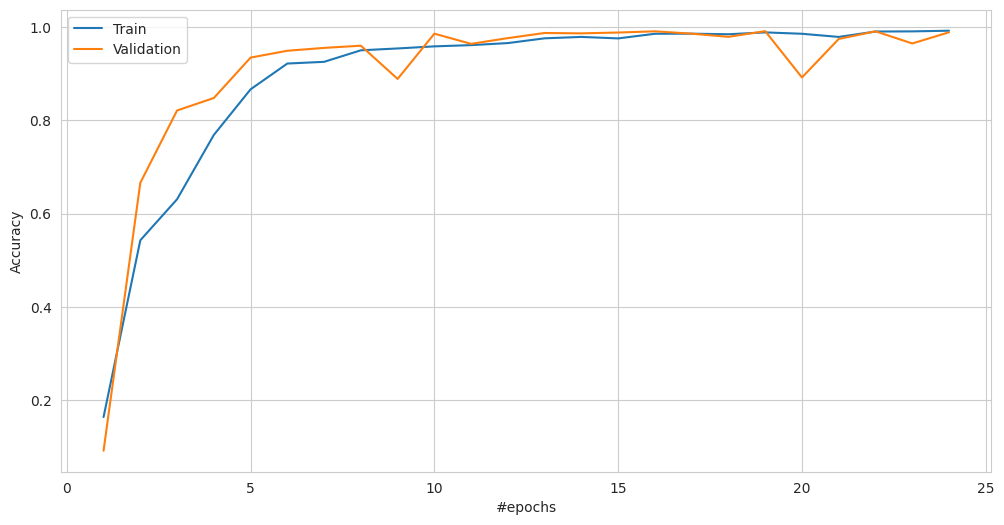

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

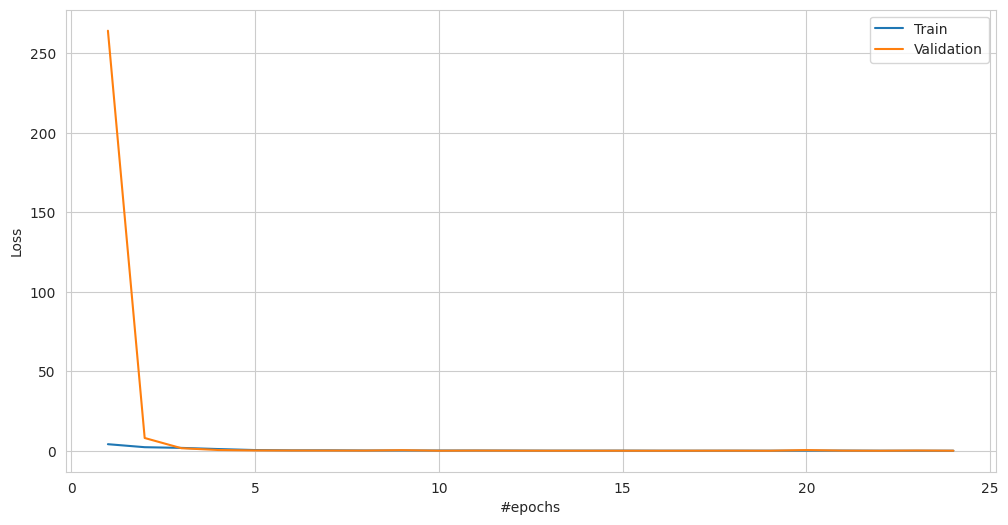

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [24]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

458/458 [==============================] - 5s 8ms/step
CPU times: user 5.83 s, sys: 384 ms, total: 6.21 s
Wall time: 6.88 s


## Classification Report

In [25]:
labels = [class_labels[i] for i in range(43)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.96      0.96      0.96        78
                              Speed limit (30km/h)       0.99      0.98      0.98       987
                              Speed limit (50km/h)       1.00      0.99      1.00       770
                              Speed limit (60km/h)       1.00      1.00      1.00       491
                              Speed limit (70km/h)       0.99      1.00      1.00       791
                              Speed limit (80km/h)       1.00      1.00      1.00       796
                       End of speed limit (80km/h)       1.00      1.00      1.00       300
                             Speed limit (100km/h)       1.00      0.99      1.00       240
                             Speed limit (120km/h)       0.99      0.99      0.99       147
                                        No passing       1.00      1.00      1.

## Confusion Matrix

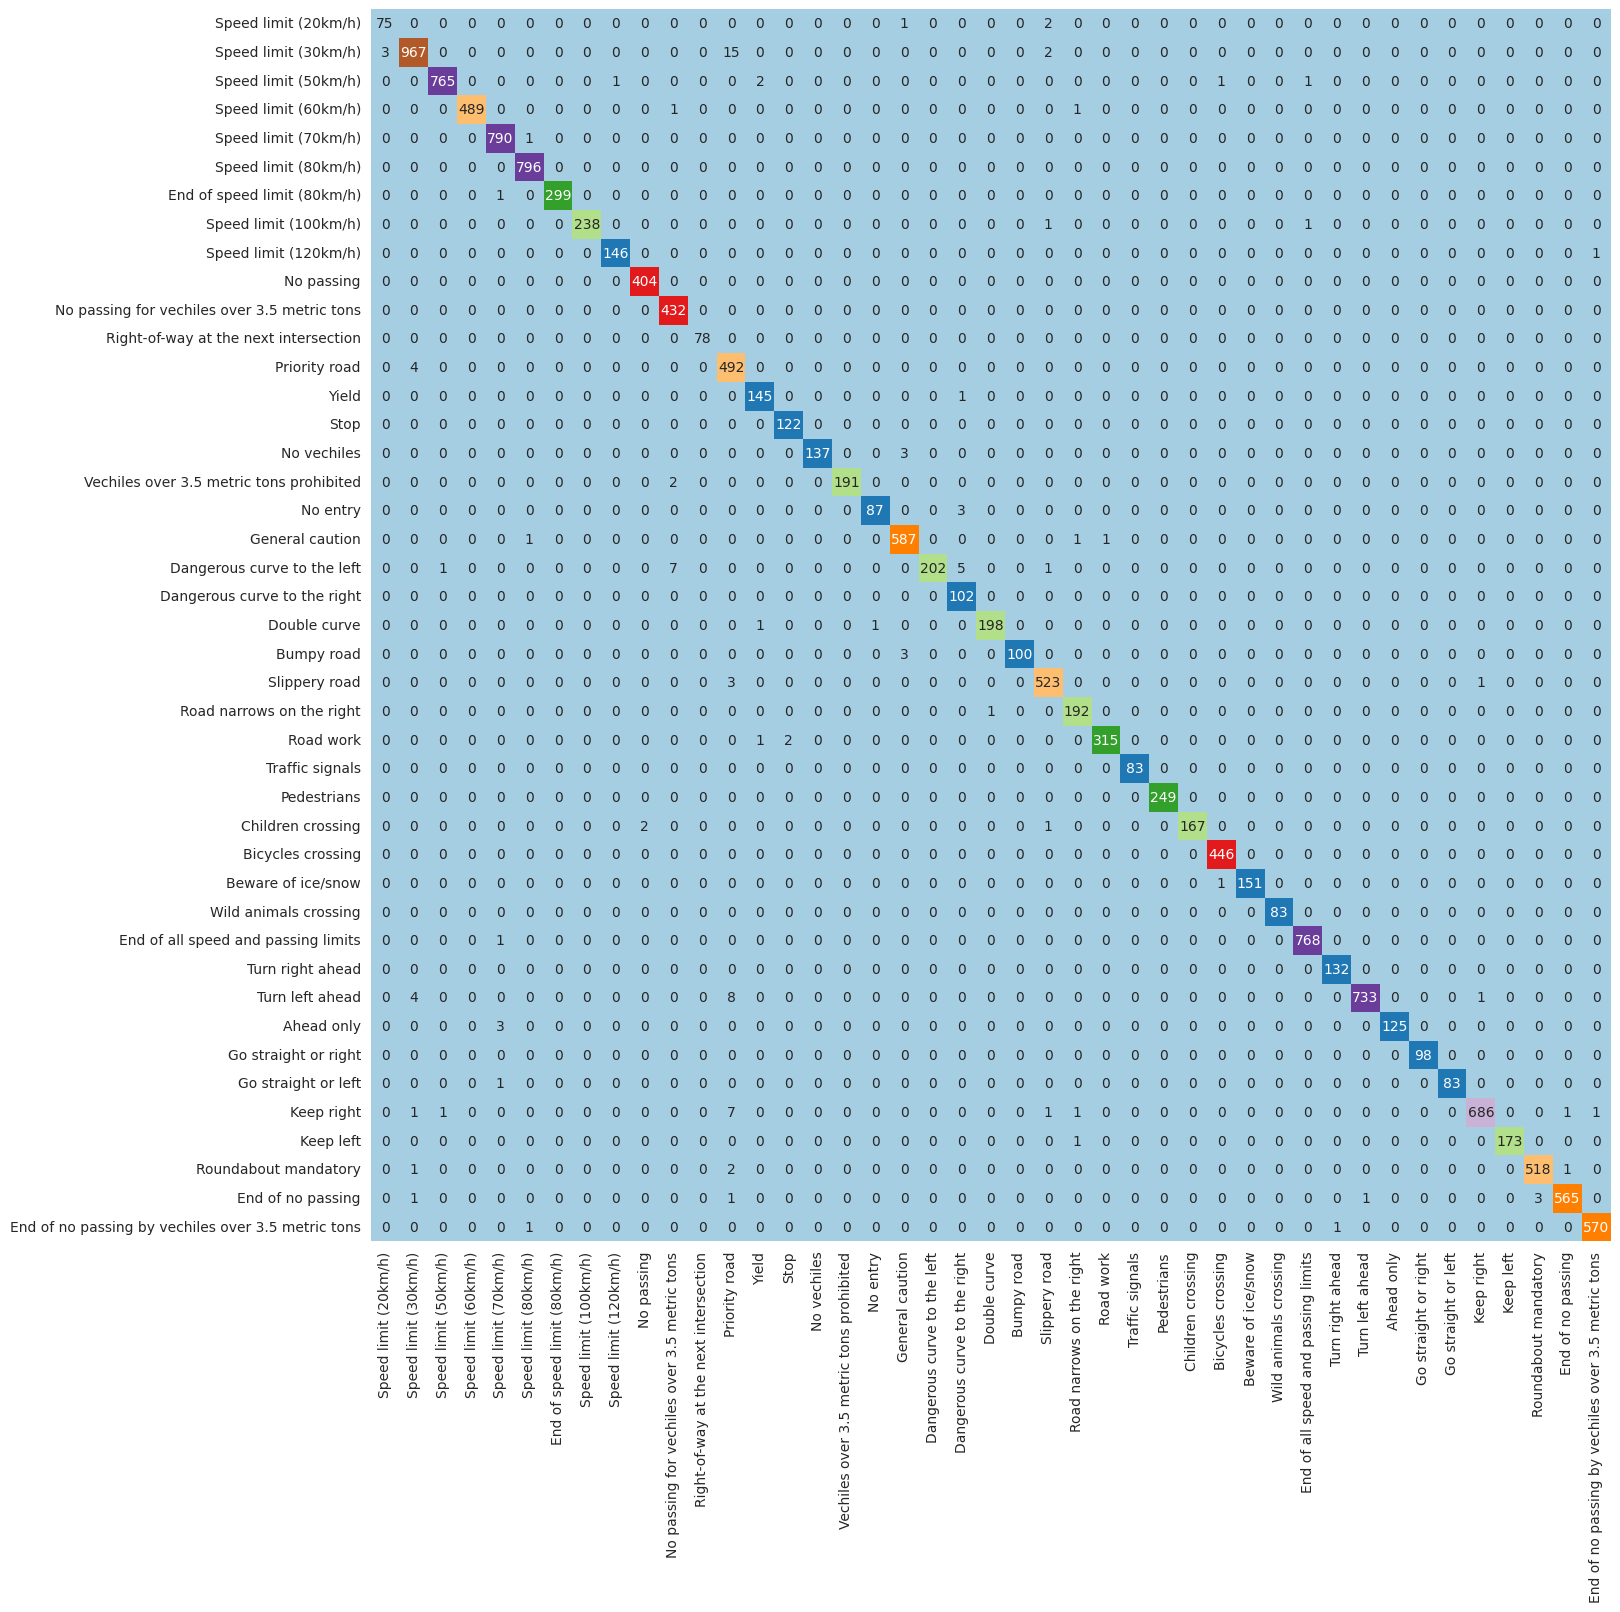

In [26]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [30]:
import pandas as pd

# Sample data, replace with your actual data
class_labels = ['Class1', 'Class2', 'Class3', 'Class4']
classwise_acc = [90.5, 80.4, 75.2, 85.6]

# Create the DataFrame
cls_acc = pd.DataFrame({'Class_Label': class_labels, 'Accuracy': classwise_acc})

# Format the DataFrame, hide the index, and add a bar
styled_cls_acc = cls_acc.style.format({"Accuracy": "{:,.2f}"}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th', 'props': [('text-align', 'center')]
}]).bar(subset=["Accuracy"], color='tomato')

# Display the styled DataFrame
styled_cls_acc

## Finally, Lets see the predictions of **unseen data**

1/1 [==============================] - 0s 35ms/step


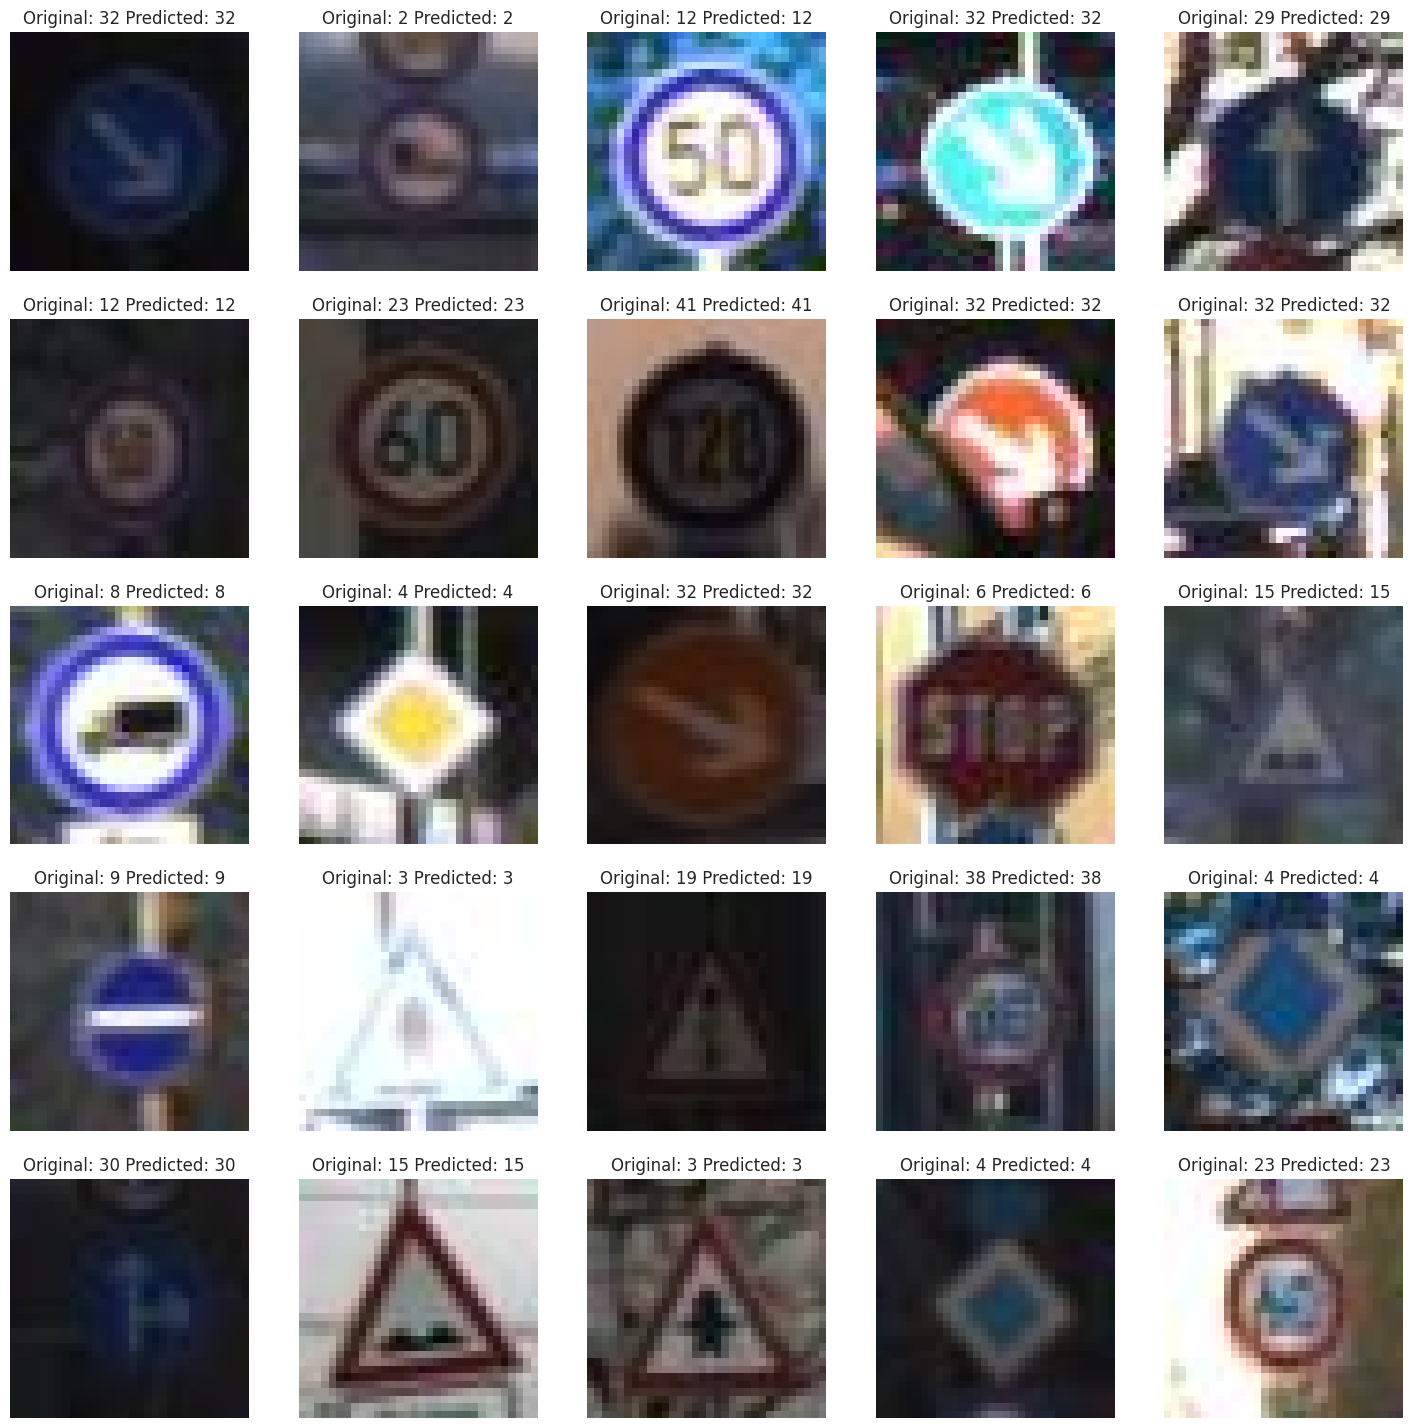

In [31]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

---